# DEMO theory

This notebook is a walkthrough of the theory code

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sb

from copy      import deepcopy
from itertools import product

from theory_code.distance_theory import TheoryCalcs

#Plotting
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import rc

rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 18})

red    = '#8e001c'
yellow = '#ffb302'

sidelegend = {'bbox_to_anchor': (1.04,0.5), 
              'loc': "center left",
              'frameon': False}
bottomlegend = {'bbox_to_anchor': (0.35,-0.2), 
                'loc': "center left",
                'frameon': False,
                'ncols': 3}

# Basic cosmology run

This part of the DEMO shows how to get the basic cosmological quantities, with the possibility of including custom cosmological models

## Computational settings

The theory code needs some computational settings to decide the range in redshift where things are computed

In [2]:
settings = {'zmin': 0.001,
            'zmax': 1000.,
            'Nz': 10000}

## Cosmology

This set of parameters computes the basic cosmological ingredients (distances, Hubble parameter, etc...)

This can be done in different ways:

- **Standard:** standard CAMB calculations
- **Custom:** placeholder for custom cosmology

This is specified by the cosmology key passed in the parameters dictionary.

### Standard cosmology

For standard cosmology, the code relies on CAMB and accepts as input the parameters known by this code.
We use the Planck 2018 best fit as a fiducial

In [3]:
standard_params = {'cosmology': 'Standard',
                   'parameters':{'H0': 67.36,
                                 'omch2': 0.1200,
                                 'ombh2': 0.02237,
                                 'omk': 0.,
                                 'omnuh2': 0.0006442,
                                 'nnu': 3.}}

### Custom cosmology

This is a placeholder for a possible modified cosmology. The expansion is computed by a custom function (`call_custom` in distance_theory.py)

In this placeholder we work with a toy model where the evolution of the matter density is modified w.r.t. to $\Lambda$CDM

$$
\rho_m(z) = \rho_m^0\,(1+z)^{3+\Delta}
$$

In [4]:
custom_params = {'cosmology': 'Custom',
                 'parameters': {'H0': 67.36,
                                'omegam': 0.3153,
                                'Delta': 0.1}}

## Fiducial cosmology

This is needed to compute some of the ditance related quantities for BAO
**ASSUMES $\Lambda$CDM!!**

In [5]:
fiducial = {'H0': 67.36,
            'omch2': 0.1200,
            'ombh2': 0.02237,
            'omk': 0.,
            'omnuh2': 0.0006442,
            'nnu': 3.}

### Supernova magnitude model

The code outputs also the apparent magnitude of supernovae as a function of redshift.
This rquires passing a model for the absolute magnitude $M_B$.

Currently, only a constant model is available (but stay tuned)

In [6]:
SNmodel = {'model': 'constant',
           'MB': -19.2435}

## Running the code

In [7]:
standard_results = TheoryCalcs(settings,standard_params,SNmodel,fiducial,feedback=True)
custom_results   = TheoryCalcs(settings,custom_params,SNmodel,fiducial,feedback=True)

Running standard CAMB...
CAMB done in 0.73 s

Computing LCDM fiducial
Running custom cosmology...
Custom cosmology done in 0.99 s

Computing LCDM fiducial


/home/Matteo/Projects/GW_projects/DDR/theory_code/distance_theory.py:185: RuntimeWarning: divide by zero encountered in log10
  mB = interp1d(self.zcalc,5*np.log10(dL(self.zcalc))+MB(self.zcalc)+25,kind='linear')


### Output

The output of the theory code is a set of cosmological quantities, returned as attributes of the class

- H_Mpc: $H(z)$ in Mpc$^{-1}$
- H_kmsMpc: $H(z)$ in Km s$^{-1}$ Mpc$^{-1}$
- DM: $D_M=d_C(z)$ (add curvature here)
- DH: $D_H=1/H(z)$
- DV: $D_V=(z\,d_C^2(z)/H(z))^{1/3}$
- dA: $d_A(z)=d_C/(1+z)$
- DL_EM: luminosity distance for EM sources
- DL_GW: luminosity distance for gravitational sources
- comoving: $d_C$
- rdrag: $r_d$ sound horizon at the drag epoch
- omegaL: current value of the dark energy density
- mB: apparent magnitude of SN
- alpha_iso: $\alpha_{\rm iso}(z)$
- alpha_AP: $\alpha_{\rm AP}(z)$
- DV_rd: $D_V/r_{\rm d}$
- DM_DH: $D_M(z)/D_H(z)$
- DM_rd: $D_M(z)/r_{\rm d}$
- DH_rd: $D_H(z)/r_{\rm d}$

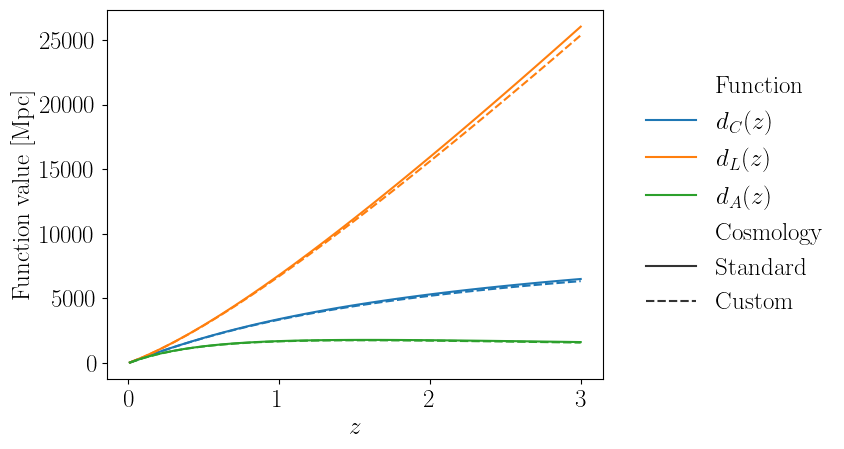

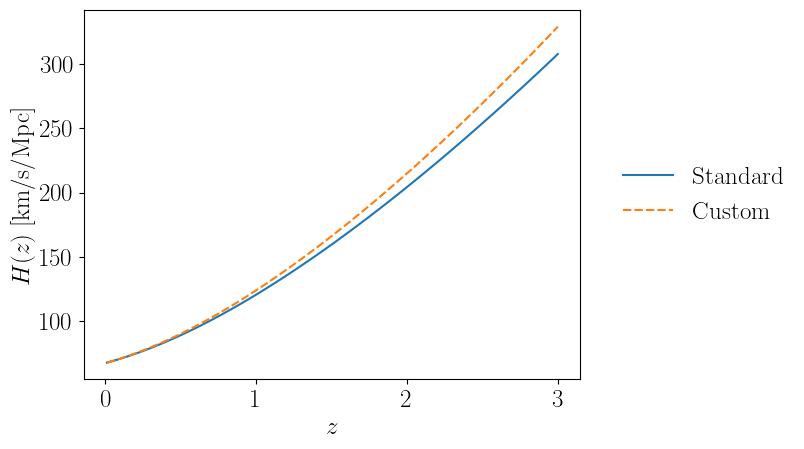

In [8]:
zplot = np.linspace(0.01,3,100)

std_df = pd.DataFrame({'z': zplot,
                       r'$d_C(z)$': standard_results.comoving(zplot),
                       r'$d_L(z)$': standard_results.DL_EM(zplot),
                       r'$d_A(z)$': standard_results.dA(zplot),
                       r'$H(z)$': standard_results.H_kmsMpc(zplot),
                       'Cosmology': 'Standard'})

std_melt_df = pd.melt(std_df,id_vars=['z','Cosmology'],value_vars=[r'$d_C(z)$',r'$d_L(z)$',r'$d_A(z)$'],
                      var_name='Function',value_name='value')

cus_df = pd.DataFrame({'z': zplot,
                       r'$d_C(z)$': custom_results.comoving(zplot),
                       r'$d_L(z)$': custom_results.DL_EM(zplot),
                       r'$d_A(z)$': custom_results.dA(zplot),
                       r'$H(z)$': custom_results.H_kmsMpc(zplot),
                       'Cosmology': 'Custom'})

cus_melt_df = pd.melt(cus_df,id_vars=['z','Cosmology'],value_vars=[r'$d_C(z)$',r'$d_L(z)$',r'$d_A(z)$'],
                      var_name='Function',value_name='value')

results = pd.concat([std_melt_df,cus_melt_df],ignore_index=True)
#results = results[results['Cosmology']=='Custom']
plt.figure()
sb.lineplot(results,x='z',y='value',hue='Function',style='Cosmology')
plt.xlabel(r'$z$')
plt.ylabel('Function value [Mpc]')
plt.legend(**sidelegend);


std_melt_df = pd.melt(std_df,id_vars=['z','Cosmology'],value_vars=[r'$H(z)$'],
                      var_name='Function',value_name='value')

cus_melt_df = pd.melt(cus_df,id_vars=['z','Cosmology'],value_vars=[r'$H(z)$'],
                      var_name='Function',value_name='value')

results = pd.concat([std_melt_df,cus_melt_df],ignore_index=True)
#results = results[results['Cosmology']=='Custom']
plt.figure()
sb.lineplot(results,x='z',y='value',hue='Cosmology',style='Cosmology')
plt.xlabel(r'$z$')
plt.ylabel(r'$H(z)$ [km/s/Mpc]')
plt.legend(**sidelegend);

### Reproducing DESI plots

### Running DESI best-fit

In [9]:
DESI_params = {'cosmology': 'Standard',
               'parameters':{'H0': 68.51,
                             'omegam': 0.2977,
                             'ombh2': 0.02218,
                             'omk': 0.,
                             'omnuh2': 0.0006442,
                             'nnu': 3.}}

DESI_params['parameters']['omch2'] = (DESI_params['parameters']['omegam']*(DESI_params['parameters']['H0']/100)**2-
                                      DESI_params['parameters']['ombh2']-DESI_params['parameters']['omnuh2']) 

del DESI_params['parameters']['omegam']

In [10]:
DESI_results = TheoryCalcs(settings,DESI_params,SNmodel,fiducial,feedback=True)

Running standard CAMB...
CAMB done in 0.61 s

Computing LCDM fiducial


In [20]:
datavec = pd.read_csv('data/DESI_table.txt',sep='\t',header=0)
print(datavec)

       z   DV_rd  DV_rd_err  DM_DH  DM_DH_err  r_VMH  alpha_iso  \
0  0.295   7.942      0.075    NaN        NaN    NaN     0.9857   
1  0.510  12.720      0.099  0.622      0.017  0.050     0.9911   
2  0.706  16.050      0.110  0.892      0.021 -0.018     0.9749   
3  0.934  19.721      0.091  1.223      0.019  0.056     0.9886   
4  1.321  24.252      0.174  1.948      0.045  0.202     0.9911   
5  1.484  26.055      0.398  2.386      0.136  0.044     1.0032   
6  2.330  31.267      0.256  4.518      0.097  0.574     0.9971   

   alpha_iso_err  alpha_AP  alpha_AP_err   DM_rd   DH_rd  DM_rd_err  \
0         0.0093       NaN           NaN     NaN     NaN        NaN   
1         0.0077    0.9555        0.0261  13.588  21.863      0.167   
2         0.0067    0.9842        0.0227  17.351  19.455      0.177   
3         0.0046    1.0237        0.0157  21.576  17.641      0.152   
4         0.0071    1.0257        0.0237  27.601  14.176      0.318   
5         0.0153    0.9885        0.0

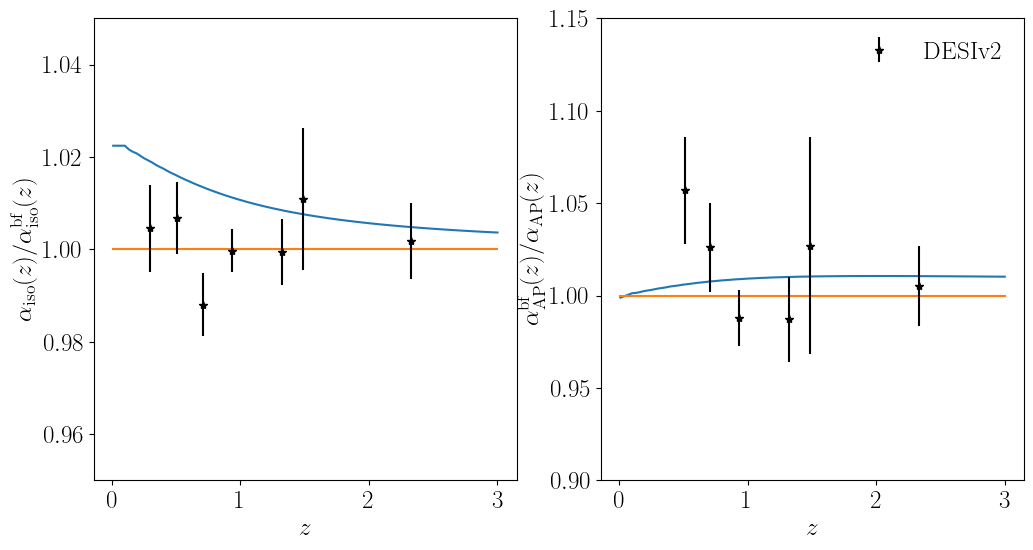

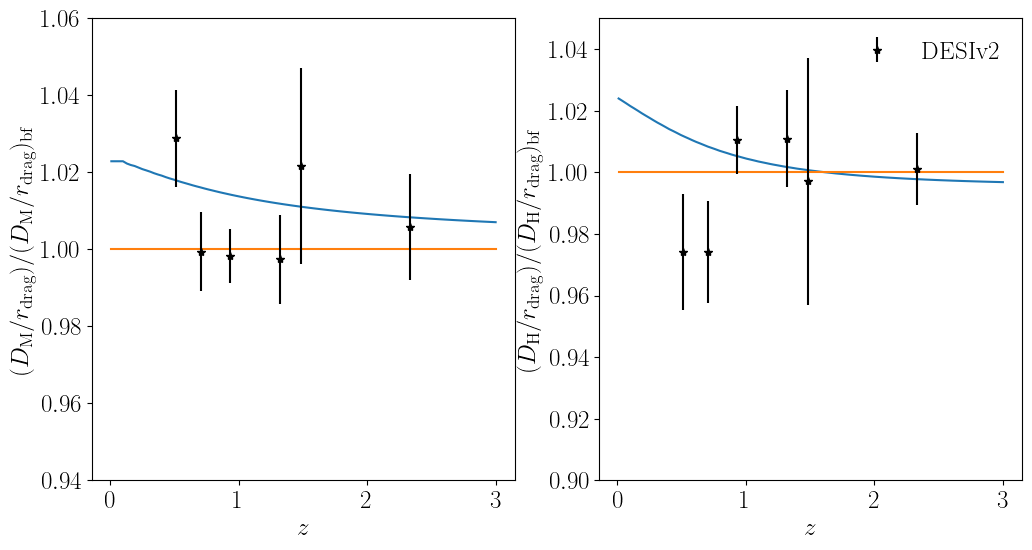

In [22]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
ax[0].plot(zplot,standard_results.alpha_iso(zplot)/DESI_results.alpha_iso(zplot))
ax[0].plot(zplot,DESI_results.alpha_iso(zplot)/DESI_results.alpha_iso(zplot))
ax[0].errorbar(datavec['z'],datavec['alpha_iso']/DESI_results.alpha_iso(datavec['z']),
               yerr=datavec['alpha_iso_err']/DESI_results.alpha_iso(datavec['z']),
               ls='',marker='*',color='black',label='DESIv2')
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$\alpha_{\rm iso}(z)/\alpha_{\rm iso}^{\rm bf}(z)$')
ax[0].set_ylim([0.95,1.05])

ax[1].plot(zplot,DESI_results.alpha_AP(zplot)/standard_results.alpha_AP(zplot))
ax[1].plot(zplot,DESI_results.alpha_AP(zplot)/DESI_results.alpha_AP(zplot))
ax[1].errorbar(datavec['z'],datavec['DM_DH']/DESI_results.DM_DH(datavec['z']),
               yerr=datavec['DM_DH_err']/DESI_results.DM_DH(datavec['z']),
               ls='',marker='*',color='black',label='DESIv2')
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$\alpha_{\rm AP}^{\rm bf}(z)/\alpha_{\rm AP}(z)$')
ax[1].legend(loc='best',frameon=False)
ax[1].set_ylim([0.9,1.15]);

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
ax[0].plot(zplot,standard_results.DM_rd(zplot)/DESI_results.DM_rd(zplot))
ax[0].plot(zplot,DESI_results.DM_rd(zplot)/DESI_results.DM_rd(zplot))
ax[0].errorbar(datavec['z'],datavec['DM_rd']/DESI_results.DM_rd(datavec['z']),
               yerr=datavec['DM_rd_err']/DESI_results.DM_rd(datavec['z']),
               ls='',marker='*',color='black',label='DESIv2')
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$(D_{\rm M}/r_{\rm drag})/(D_{\rm M}/r_{\rm drag})_{\rm bf}$')
ax[0].set_ylim([0.94,1.06])

ax[1].plot(zplot,standard_results.DH_rd(zplot)/DESI_results.DH_rd(zplot))
ax[1].plot(zplot,DESI_results.DH_rd(zplot)/DESI_results.DH_rd(zplot))
ax[1].errorbar(datavec['z'],datavec['DH_rd']/DESI_results.DH_rd(datavec['z']),
               yerr=datavec['DH_rd_err']/DESI_results.DH_rd(datavec['z']),
               ls='',marker='*',color='black',label='DESIv2')
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$(D_{\rm H}/r_{\rm drag})/(D_{\rm H}/r_{\rm drag})_{\rm bf}$')
ax[1].legend(loc='best',frameon=False)
ax[1].set_ylim([0.9,1.05]);

# Distance Duality Relation

The code allows to account for deviations from the standard DDR by computing the function

$$
\eta(z)=\frac{d_L(z)}{(1+z)^2d_A(z)}
$$

The parameters controlling this effect are passed through a `DDR` key in the parameters dictionary. If such a key does not exist, the code assumes standard DDR.

The parameterization for this function is:

$$
\eta(z) = (1+a\,z^n)^\epsilon
$$

This function will be used to compute the luminosity distance as

$$
d_L(z) =\eta(z)\,(1+z)^2\,d_A(z)
$$

with $d_A$ computed as above.

This model is selected with setting `eta_model` to `polynomial` in the DDR parameters dictionary. Currently, no other options are available for the parameterization of $\eta(z)$.

The code also allows to use the Pad\`e approximant to model $\eta(z)$ in such a way that it reduces to the standard at very high redshift. This option is selected by setting `use_pade` to True.

Notice that the code allows by default to use different parameters for the violation of DDR in the electromagnetic sector (EM) and for gravitational waves (GW), thus possibly accounting for models where the violation is different in the two sectors

**MMnote: maybe we could make them automatically identical if only one sector is included? For the moment you always need to put both**

In [13]:
DDR_parameters = {'eta_model': 'polynomial',
                  'use_pade': False,
                  'parameters': {'a_EM': 1,
                                 'n_EM': 1,
                                 'epsilon0_EM': 0.1,
                                 'a_GW': 1,
                                 'n_GW': 1,
                                 'epsilon0_GW': 0.1}}

pade_parameters = deepcopy(DDR_parameters)
pade_parameters['use_pade'] = True

In [14]:
DDR_results  = TheoryCalcs(settings,standard_params,SNmodel,fiducial,DDR=DDR_parameters,feedback=True)
pade_results = TheoryCalcs(settings,standard_params,SNmodel,fiducial,DDR=pade_parameters,feedback=True)

Running standard CAMB...
CAMB done in 1.00 s

Computing LCDM fiducial
Computing DDR functions...
DDR done in 0.00 s
Running standard CAMB...
CAMB done in 0.78 s

Computing LCDM fiducial
Computing DDR functions...
DDR done in 0.00 s


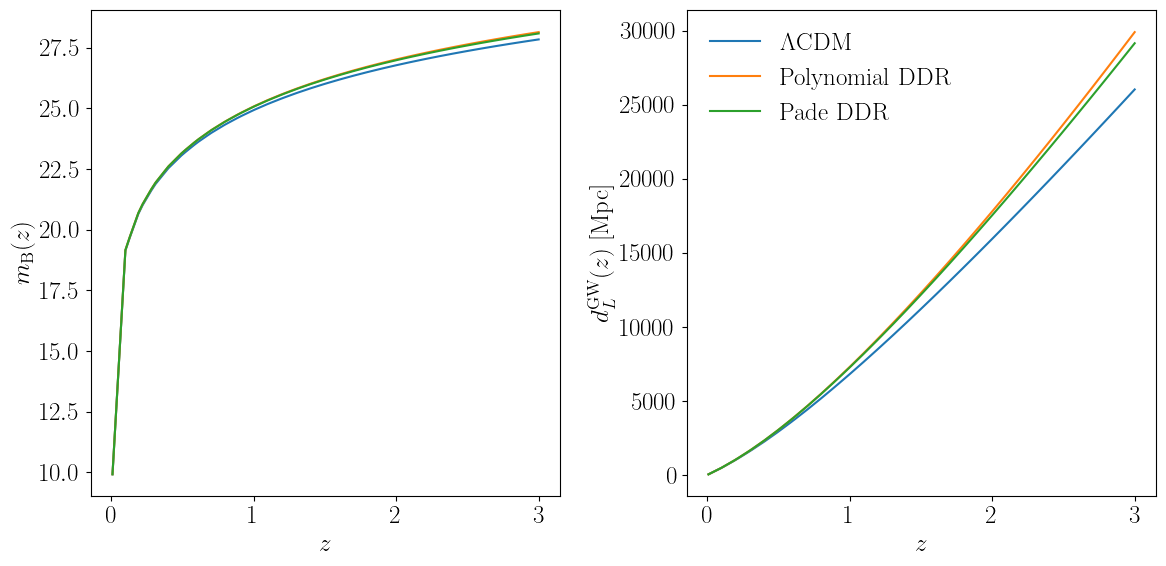

In [19]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
ax[0].plot(zplot,standard_results.mB(zplot),label=r'$\Lambda$CDM')
ax[0].plot(zplot,DDR_results.mB(zplot),label=r'Polynomial DDR')
ax[0].plot(zplot,pade_results.mB(zplot),label=r'Pade DDR')
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$m_{\rm B}(z)$')

ax[1].plot(zplot,standard_results.DL_GW(zplot),label=r'$\Lambda$CDM')
ax[1].plot(zplot,DDR_results.DL_GW(zplot),label=r'Polynomial DDR')
ax[1].plot(zplot,pade_results.DL_GW(zplot),label=r'Pade DDR')
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$d_L^{\rm GW}(z)$ [Mpc]')
ax[1].legend(loc='best',frameon=False)
plt.tight_layout();